# Titanic from Kaggle

I use random forest and grid search for this project...

### Step 1 : A Quick Preliminary Model to Set a Benchmark

In [111]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train['Type']='Train' #Create a flag for Train and Test Data set
test['Type']='Test'
fullData = pd.concat([train,test],axis=0) #Combined both Train and Test Data set

ID_col = ['PassengerId']
target_col = ["Survived"]
other_col=['Type'] 

cat_cols = list(set(list(fullData.columns[fullData.dtypes=='object']))-set(other_col))
num_cols= list(set(list(fullData.columns))-set(cat_cols)-set(ID_col)-set(target_col)-set(other_col))

#Impute Missing values (numerical and categorical)

fullData[num_cols] = fullData[num_cols].fillna(fullData[num_cols].median(),inplace=True)
fullData[cat_cols] = fullData[cat_cols].fillna(value = -9999)

for col in cat_cols:
    fullData[col] = pd.Categorical(fullData[col])

fullData[cat_cols] = fullData[cat_cols].apply(lambda x: x.cat.codes)

train=fullData[fullData['Type']=='Train']
test=fullData[fullData['Type']=='Test']    

#Modeling
X = ['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 
       'Pclass', 'Sex', 'SibSp', 'Ticket'] #'PassengerId', 'Type'

y = ['Survived']

X_train, X_test, y_train, y_test = train_test_split(train[X], train[y])

clf_rf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf_rf = clf_rf.fit(X_train[X], y_train[y].values.ravel())

accuracy_score(y_test[y],clf_rf.predict(X_test[X]))

C:\Users\Cyrus\Anaconda3\lib\site-packages\pandas\core\generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


0.83856502242152464

### It's fair for the starter but let's tune up the model and do some feature engineering

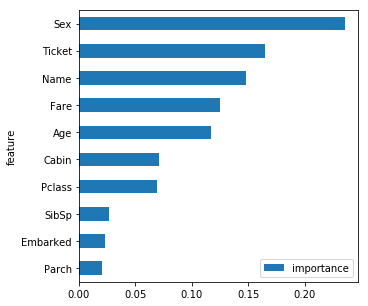

In [112]:
features = pd.DataFrame()
features['feature'] = X 
features['importance'] = clf_rf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(5, 5))

So a couple of things to do:

1- Age was one of the columns with the most missing values that I simply imputed with the median! So a better job needs to be done.

2- There has to be some info in Ticket and Name columns that we need to extract. Looking at tickets, some of them have a two parts, i.e. some first part such as A/5, STON/02. CA. etc plus a following number.
Also, Name column contains titles like Mr., Mrs. Miss. etc. 

In [115]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train['Type']='Train' 
test['Type']='Test'
fullData = pd.concat([train,test],axis=0) 

In [116]:
# Processing the Titles...

def get_titles():
    a=[]
    for i in fullData.Name:
        a.append(i.rsplit(', ')[1].split('.')[0])
    title_dictionary=set(a)
    return title_dictionary

get_titles()    

fullData['Title'] = fullData['Name'].map(lambda name:name.split(', ')[1].split('.')[0].strip())

In [117]:
# Processing the Age...

grouped_train = fullData[fullData['Type']=='Train'].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()

grouped_test = fullData[fullData['Type']=='Test'].groupby(['Sex','Pclass','Title'])
grouped_median_test = grouped_test.median()

def fillAges(row, grouped_median):
    return grouped_median.loc[row['Sex'], row['Pclass'], row['Title']]['Age'] 

fullData['Age']=fullData[fullData['Type']=='Train'].apply(lambda x : fillAges(x, grouped_median_train) if np.isnan(x['Age']) else x['Age'], axis=1)

In [118]:
fullData.drop('Name',axis=0,inplace=True)

    # encoding in dummy variable
titles_dummies = pd.get_dummies(fullData['Title'],prefix='Title')
fullData = pd.concat([fullData,titles_dummies],axis=1)

    #removing the title variable
fullData.drop('Title',axis=1,inplace=True)

In [119]:
# Processing the Fare...

    # Train
fullData.head(891).Fare.fillna(fullData.head(891).Fare.mean(), inplace=True)
    #Test
fullData.iloc[891:].Fare.fillna(fullData.iloc[891:].Fare.mean(), inplace=True)

C:\Users\Cyrus\Anaconda3\lib\site-packages\pandas\core\generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [120]:
# Processing the Embarked...

fullData.head(891).Embarked.fillna('S', inplace=True)
fullData.iloc[891:].Embarked.fillna('S', inplace=True)
    # dummy encoding 
embarked_dummies = pd.get_dummies(fullData['Embarked'],prefix='Embarked')
fullData = pd.concat([fullData,embarked_dummies],axis=1)
fullData.drop('Embarked',axis=1,inplace=True)

C:\Users\Cyrus\Anaconda3\lib\site-packages\pandas\core\generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [121]:
# Processing the Cabin...

fullData.Cabin.fillna('U', inplace=True)

    # mapping each Cabin value with the cabin letter
fullData['Cabin'] = fullData['Cabin'].map(lambda c : c[0])

    # dummy encoding ...
cabin_dummies = pd.get_dummies(fullData['Cabin'], prefix='Cabin')

fullData = pd.concat([fullData,cabin_dummies], axis=1)

fullData.drop('Cabin', axis=1, inplace=True)

In [122]:
# Processing the Sex...

fullData['Sex'] = fullData['Sex'].map({'male':1,'female':0})

In [123]:
# Processing the Pclass...

pclass_dummies = pd.get_dummies(fullData['Pclass'], prefix="Pclass")

    # adding dummy variables
fullData = pd.concat([fullData,pclass_dummies],axis=1)

    # removing "Pclass"

fullData.drop('Pclass',axis=1,inplace=True)

In [124]:
# Processing the Ticket...

def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))

    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

    # Extracting dummy variables from tickets:

fullData['Ticket'] = fullData['Ticket'].map(cleanTicket)
tickets_dummies = pd.get_dummies(fullData['Ticket'], prefix='Ticket')
fullData = pd.concat([fullData, tickets_dummies], axis=1)
fullData.drop('Ticket', inplace=True, axis=1)

In [125]:
# Making a new feature for family size...

    # the size of families (including the passenger)
fullData['FamilySize'] = fullData['Parch'] + fullData['SibSp'] + 1

    # introducing other features based on the family size
fullData['Singleton'] = fullData['FamilySize'].map(lambda s: 1 if s == 1 else 0)
fullData['SmallFamily'] = fullData['FamilySize'].map(lambda s: 1 if 2<=s<=4 else 0)
fullData['LargeFamily'] = fullData['FamilySize'].map(lambda s: 1 if 5<=s else 0)

In [126]:
fullData.drop('PassengerId', inplace=True, axis=1)

### Step 2: Fine-Tuning the Model...

In [127]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score

In [129]:
train=fullData[fullData['Type']=='Train'].drop('Type',axis='columns')
test=fullData[fullData['Type']=='Test'].drop('Type',axis='columns')

In [130]:
train.drop('Name',axis='columns', inplace=True)
test.drop('Name',axis='columns', inplace=True)

In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

X=['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'Title_Capt',
       'Title_Col', 'Title_Don', 'Title_Dona', 'Title_Dr', 'Title_Jonkheer',
       'Title_Lady', 'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle',
       'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev',
       'Title_Sir', 'Title_the Countess', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Ticket_A', 'Ticket_A4', 'Ticket_A5', 'Ticket_AQ3',
       'Ticket_AQ4', 'Ticket_AS', 'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON',
       'Ticket_FC', 'Ticket_FCC', 'Ticket_Fa', 'Ticket_LINE', 'Ticket_LP',
       'Ticket_PC', 'Ticket_PP', 'Ticket_PPP', 'Ticket_SC', 'Ticket_SCA3',
       'Ticket_SCA4', 'Ticket_SCAH', 'Ticket_SCOW', 'Ticket_SCPARIS',
       'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP', 'Ticket_SOPP',
       'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP', 'Ticket_STONO',
       'Ticket_STONO2', 'Ticket_STONOQ', 'Ticket_SWPP', 'Ticket_WC',
       'Ticket_WEP', 'Ticket_XXX', 'FamilySize', 'Singleton', 'SmallFamily',
       'LargeFamily']
y=['Survived']

X_train, X_test, y_train, y_test = train_test_split(train[X], train[y])

clf_rf = RandomForestClassifier(n_estimators=50, max_features='sqrt')

clf_rf = clf_rf.fit(X_train[X], y_train[y].values.ravel())

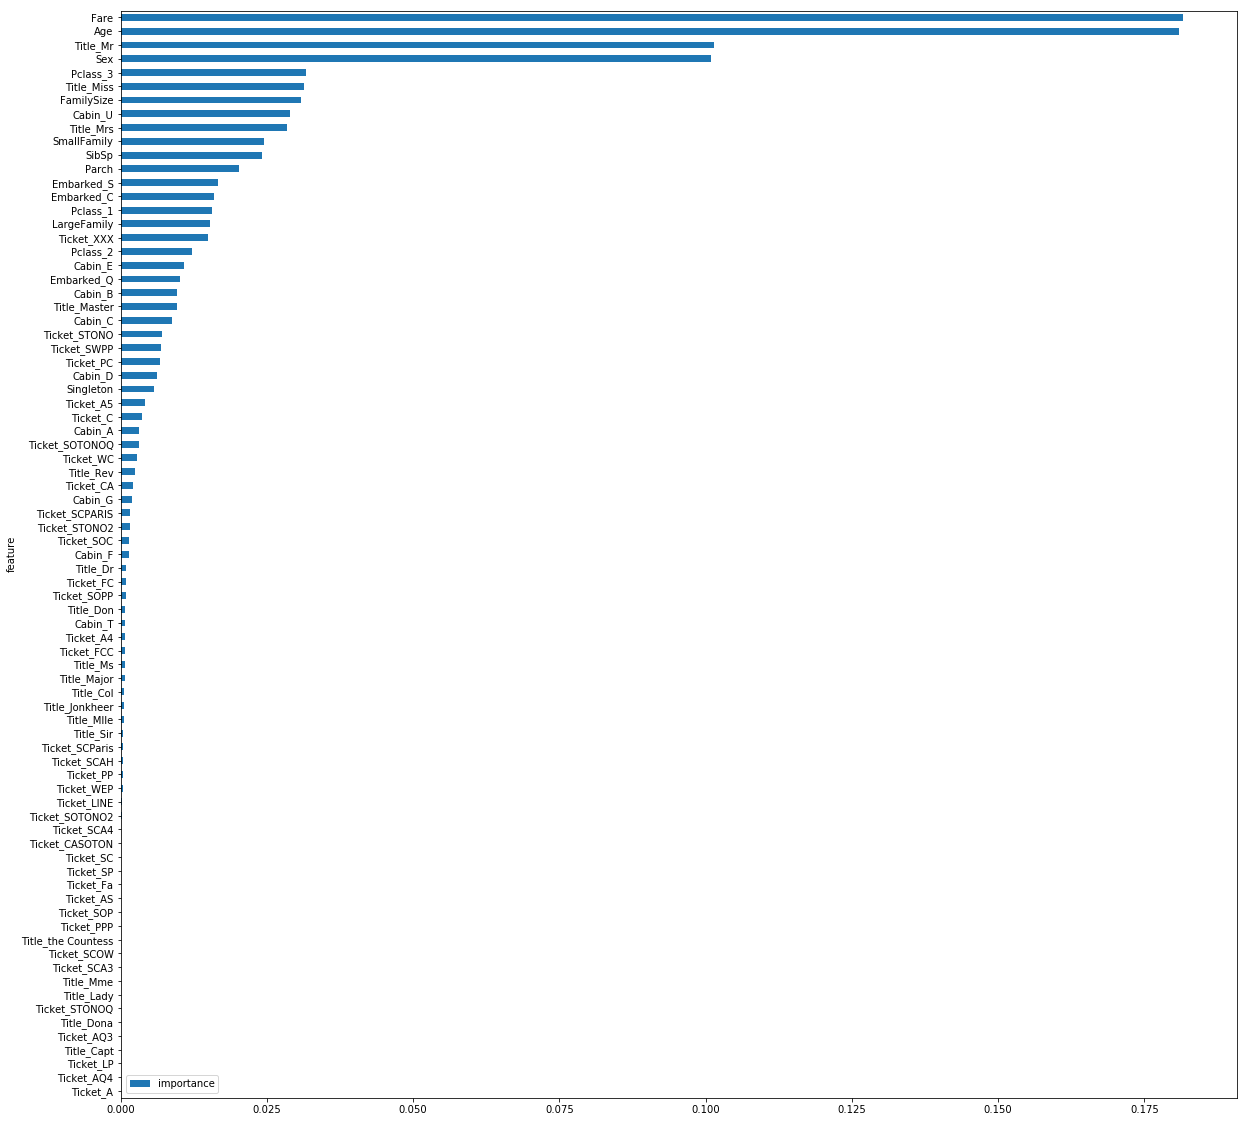

In [133]:
features = pd.DataFrame()
features['feature'] = ['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'Title_Capt',
       'Title_Col', 'Title_Don', 'Title_Dona', 'Title_Dr', 'Title_Jonkheer',
       'Title_Lady', 'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle',
       'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev',
       'Title_Sir', 'Title_the Countess', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Ticket_A', 'Ticket_A4', 'Ticket_A5', 'Ticket_AQ3',
       'Ticket_AQ4', 'Ticket_AS', 'Ticket_C', 'Ticket_CA', 'Ticket_CASOTON',
       'Ticket_FC', 'Ticket_FCC', 'Ticket_Fa', 'Ticket_LINE', 'Ticket_LP',
       'Ticket_PC', 'Ticket_PP', 'Ticket_PPP', 'Ticket_SC', 'Ticket_SCA3',
       'Ticket_SCA4', 'Ticket_SCAH', 'Ticket_SCOW', 'Ticket_SCPARIS',
       'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOP', 'Ticket_SOPP',
       'Ticket_SOTONO2', 'Ticket_SOTONOQ', 'Ticket_SP', 'Ticket_STONO',
       'Ticket_STONO2', 'Ticket_STONOQ', 'Ticket_SWPP', 'Ticket_WC',
       'Ticket_WEP', 'Ticket_XXX', 'FamilySize', 'Singleton', 'SmallFamily',
       'LargeFamily']

features['importance'] = clf_rf.feature_importances_

features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(20, 20))

In [134]:
model = SelectFromModel(clf_rf, prefit=True)
train_reduced = model.transform(train[X])
train_reduced.shape

(891, 17)

In [135]:
test_reduced = model.transform(test[X])
test_reduced.shape

(418, 17)

In [136]:
# The run_gs has to be True if gridsearch is going to run again...
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [1, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(y_train[y], n_folds=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation)

    grid_search.fit(X_train[X], y_train[y])
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(X_train[X], y_train[y].values.ravel())

In [137]:
accuracy_score(y_test[y],model.predict(X_test[X]))

0.820627802690583

Not much improvement compared to our priliminary model. Need to dig deeper...